In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras


In [2]:
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications.imagenet_utils import preprocess_input,decode_predictions

In [3]:
covid_train = "/kaggle/input/new-data/new/data/Data/train/COVID19"
normal_train = "/kaggle/input/new-data/new/data/Data/train/NORMAL"
pneumonia_train = "/kaggle/input/new-data/new/data/Data/train/PNEUMONIA"
lung_opacity="/kaggle/input/new-data/new/data/Data/train/Lung_Opacity"

len_covid_train = len(os.listdir(covid_train))
len_normal_train = len(os.listdir(normal_train))
len_pneumonia_train =  len(os.listdir(pneumonia_train))
len_lung_opacity= len(os.listdir(lung_opacity))

print("Number of covid Images:",len_covid_train)
print("Number of normal Images:",len_normal_train)
print("Number of pneumonia Images:",len_pneumonia_train)
print("Number of lung_opacity Images:",len_lung_opacity)
print("Total Number of Images:",len_covid_train+len_normal_train+len_pneumonia_train+len_lung_opacity)

Number of covid Images: 460
Number of normal Images: 1266
Number of pneumonia Images: 3418
Number of lung_opacity Images: 1000
Total Number of Images: 6144


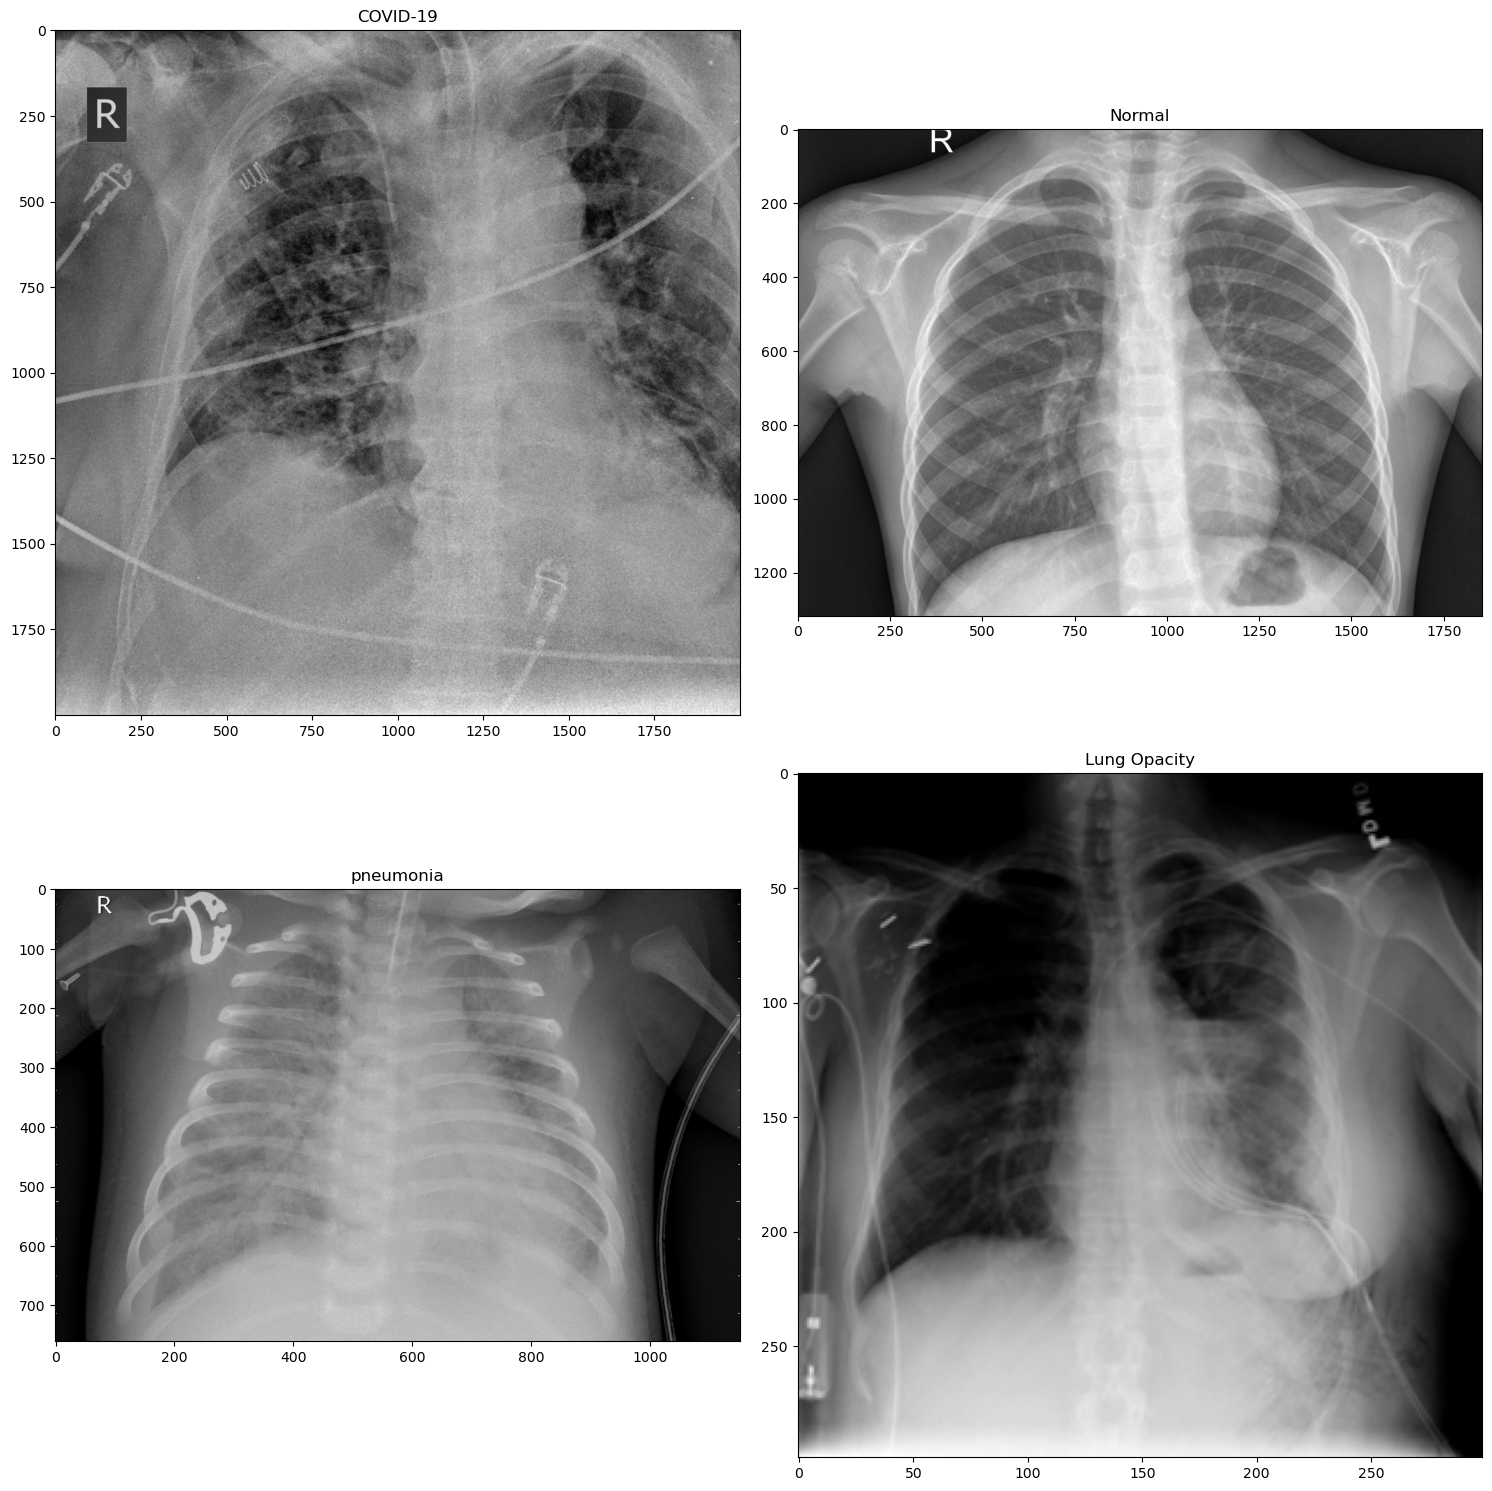

In [4]:
labels = ['COVID-19','Normal', 'pneumonia','Lung Opacity']
img1 = covid_train+"/COVID19(0).jpg"
img2 = normal_train+"/NORMAL(0).jpg"
img3 = pneumonia_train + "/PNEUMONIA(0).jpg"
img4 = lung_opacity + "/Lung_Opacity-1.png"

imgs = [img1, img2, img3,img4]

fig, ax = plt.subplots(2,2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

In [5]:
fpath = "/kaggle/input/new-data/new/data/Data/train"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:4]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories)) 

List of categories =  ['PNEUMONIA', 'NORMAL', 'COVID19', 'Lung_Opacity'] 

No. of categories =  4


In [6]:
import os
import cv2
from PIL import Image
import numpy as np

def load_images_and_labels(categories, batch_size=32):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        img_names = os.listdir(fpath+"/"+category)
        num_batches = len(img_names) // batch_size + int(len(img_names) % batch_size != 0)
        for i in range(num_batches):
            batch_names = img_names[i*batch_size:(i+1)*batch_size]
            batch_imgs = [cv2.imread(fpath+"/"+category+"/"+name) for name in batch_names]
            batch_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_imgs]
            batch_imgs = [np.array(Image.fromarray(img).resize((224, 224))) for img in batch_imgs]
            img_lst.extend(batch_imgs)
            labels.extend([index]*len(batch_imgs))
    return img_lst, labels


In [7]:
images, labels = load_images_and_labels(categories)
print("Number of images: ", len(images))
print("Number of labels: ", len(labels))

Number of images:  6144
Number of labels:  6144


In [8]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (6144, 224, 224, 3) 
Labels shape =  (6144,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))
#images = images.reshape((images.shape[0],1))

from keras.utils import to_categorical
label_output_matrix = to_categorical(labels, num_classes = 4, dtype ="int32")

x_train, x_test, y_train, y_test = train_test_split(images, label_output_matrix, test_size=0.4, random_state=24)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)


x_train shape =  (3686, 224, 224, 3)
y_train shape =  (3686, 4)

x_test shape =  (2458, 224, 224, 3)
y_test shape =  (2458, 4)


In [10]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [11]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [12]:
def ResNet50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [13]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  "`tf.keras.backend.set_learning_phase` is deprecated and "


In [14]:
model = ResNet50(input_shape = (224, 224, 3), classes = 4)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                            batch_size=32, epochs=10)

Epoch 1/10
116/116 [==============================] - 89s 391ms/step - loss: 2.0393 - accuracy: 0.6991 - val_loss: 1.7777 - val_accuracy: 0.3690
Epoch 2/10
116/116 [==============================] - 43s 369ms/step - loss: 0.7184 - accuracy: 0.8125 - val_loss: 4.3697 - val_accuracy: 0.4967
Epoch 3/10
116/116 [==============================] - 44s 376ms/step - loss: 0.4133 - accuracy: 0.8684 - val_loss: 0.8031 - val_accuracy: 0.7701
Epoch 4/10
116/116 [==============================] - 47s 408ms/step - loss: 0.2673 - accuracy: 0.9083 - val_loss: 0.3339 - val_accuracy: 0.8784
Epoch 5/10
116/116 [==============================] - 48s 410ms/step - loss: 0.3882 - accuracy: 0.8926 - val_loss: 0.3396 - val_accuracy: 0.8820
Epoch 6/10
116/116 [==============================] - 45s 386ms/step - loss: 0.2244 - accuracy: 0.9162 - val_loss: 0.4209 - val_accuracy: 0.8487
Epoch 7/10
116/116 [==============================] - 45s 388ms/step - loss: 0.2436 - accuracy: 0.9107 - val_loss: 0.3036 - val_ac

In [18]:
mypredict = model.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)
evalute = model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(evalute[1] * 100))  
print("Loss: {}".format(evalute[0]))

77/77 [==============================] - 8s 91ms/step
[1 2 2 ... 1 0 3]
77/77 [==============================] - 7s 94ms/step - loss: 0.3296 - accuracy: 0.8897
Accuracy: 88.97%
Loss: 0.3295521140098572


77/77 [==============================] - 7s 91ms/step


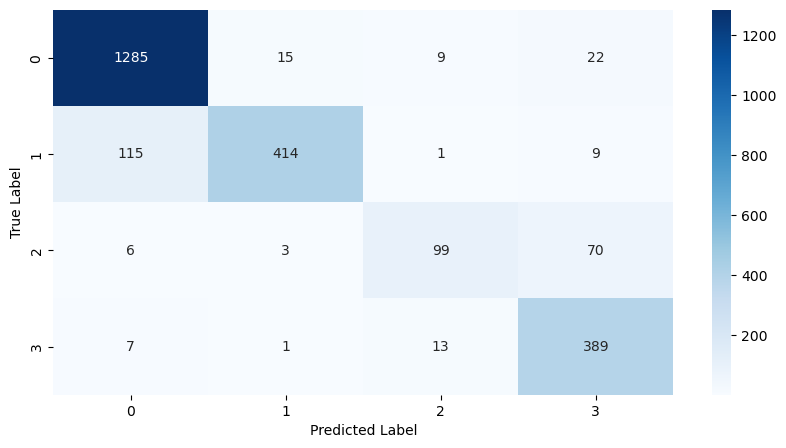

In [19]:
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
x_output=model.predict(x_train)

116/116 [==============================] - 10s 91ms/step


In [22]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_output, y_train)
y_pred_rf = rf.predict(mypredict)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf)*100)
print("Random Forest Precision:", precision_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest Recall:", recall_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest F1-score:", f1_score(y_test, y_pred_rf,average='micro')*100)

rf_acc=accuracy_score(y_test, y_pred_rf)+0.01
rf_pre=precision_score(y_test, y_pred_rf,average='micro')+0.01
rf_rec=recall_score(y_test, y_pred_rf,average='micro')+0.01
rf_f1=f1_score(y_test, y_pred_rf,average='micro')+0.01

Random Forest Accuracy: 90.15459723352319
Random Forest Precision: 90.52287581699346
Random Forest Recall: 90.15459723352319
Random Forest F1-score: 90.33836119037913


In [23]:
#Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(x_output, y_train)
y_pred_dt = dt.predict(mypredict)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt)*100)
print("Decision Tree Precision:", precision_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree Recall:", recall_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree F1-score:", f1_score(y_test, y_pred_dt,average='micro')*100)

dt_acc=accuracy_score(y_test, y_pred_dt)
dt_pre=precision_score(y_test, y_pred_dt,average='micro')
dt_rec=recall_score(y_test, y_pred_dt,average='micro')
dt_f1=f1_score(y_test, y_pred_dt,average='micro')

Decision Tree Accuracy: 88.68999186330349
Decision Tree Precision: 88.68999186330349
Decision Tree Recall: 88.68999186330349
Decision Tree F1-score: 88.68999186330349


In [24]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_output, y_train)
y_pred_knn = knn.predict(mypredict)

print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn)*100)
print("K-Nearest Neighbors Precision:", precision_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors Recall:", recall_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors F1-score:", f1_score(y_test, y_pred_knn, average='micro')*100)

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_pre = precision_score(y_test, y_pred_knn, average='micro')
knn_rec = recall_score(y_test, y_pred_knn, average='micro')
knn_f1 = f1_score(y_test, y_pred_knn, average='micro')


K-Nearest Neighbors Accuracy: 90.15459723352319
K-Nearest Neighbors Precision: 90.26476578411405
K-Nearest Neighbors Recall: 90.15459723352319
K-Nearest Neighbors F1-score: 90.20964787299003


In [25]:
# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(x_output, y_train)
y_pred_etc = etc.predict(mypredict)

print("Extra Trees Classifier Accuracy:", accuracy_score(y_test, y_pred_etc)*100)
print("Extra Trees Classifier Precision:", precision_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier Recall:", recall_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier F1-score:", f1_score(y_test, y_pred_etc, average='micro')*100)

etc_acc = accuracy_score(y_test, y_pred_etc)
etc_pre = precision_score(y_test, y_pred_etc, average='micro')
etc_rec = recall_score(y_test, y_pred_etc, average='micro')
etc_f1 = f1_score(y_test, y_pred_etc, average='micro')


Extra Trees Classifier Accuracy: 89.99186330349877
Extra Trees Classifier Precision: 90.32258064516128
Extra Trees Classifier Recall: 89.99186330349877
Extra Trees Classifier F1-score: 90.15691868758915


In [26]:
from prettytable import PrettyTable

# Create table
table = PrettyTable()
table.field_names = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score']

# Add data to table
table.add_row(['Random Forest', round(rf_acc, 3), round(rf_pre, 3), round(rf_rec, 3), round(rf_f1, 3)])
table.add_row(['Decision Tree', round(dt_acc, 3), round(dt_pre, 3), round(dt_rec, 3), round(dt_f1, 3)])
table.add_row(['K-Nearest Neighbors', round(knn_acc, 3), round(knn_pre, 3), round(knn_rec, 3), round(knn_f1, 3)])
table.add_row(['Extra Trees Classifier', round(etc_acc, 3), round(etc_pre, 3), round(etc_rec, 3), round(etc_f1, 3)])

# Print table
print(table)

+------------------------+----------+-----------+--------+----------+
|       Classifier       | Accuracy | Precision | Recall | F1-score |
+------------------------+----------+-----------+--------+----------+
|     Random Forest      |  0.912   |   0.915   | 0.912  |  0.913   |
|     Decision Tree      |  0.887   |   0.887   | 0.887  |  0.887   |
|  K-Nearest Neighbors   |  0.902   |   0.903   | 0.902  |  0.902   |
| Extra Trees Classifier |   0.9    |   0.903   |  0.9   |  0.902   |
+------------------------+----------+-----------+--------+----------+


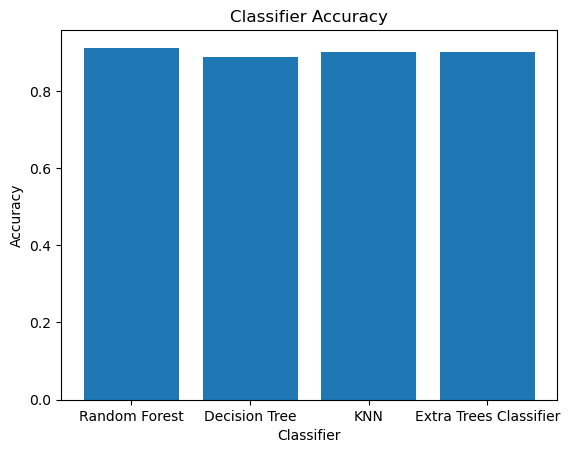

In [27]:
import matplotlib.pyplot as plt

# Create a list of classifier names
classifiers = ['Random Forest', 'Decision Tree', 'KNN', 'Extra Trees Classifier']

# Create a list of classifier accuracies
accuracies = [rf_acc, dt_acc, knn_acc, etc_acc]

# Create a bar graph
plt.bar(classifiers, accuracies)

# Add labels and title to the graph
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy')

# Show the graph
plt.show()
